THE FINAL CODE

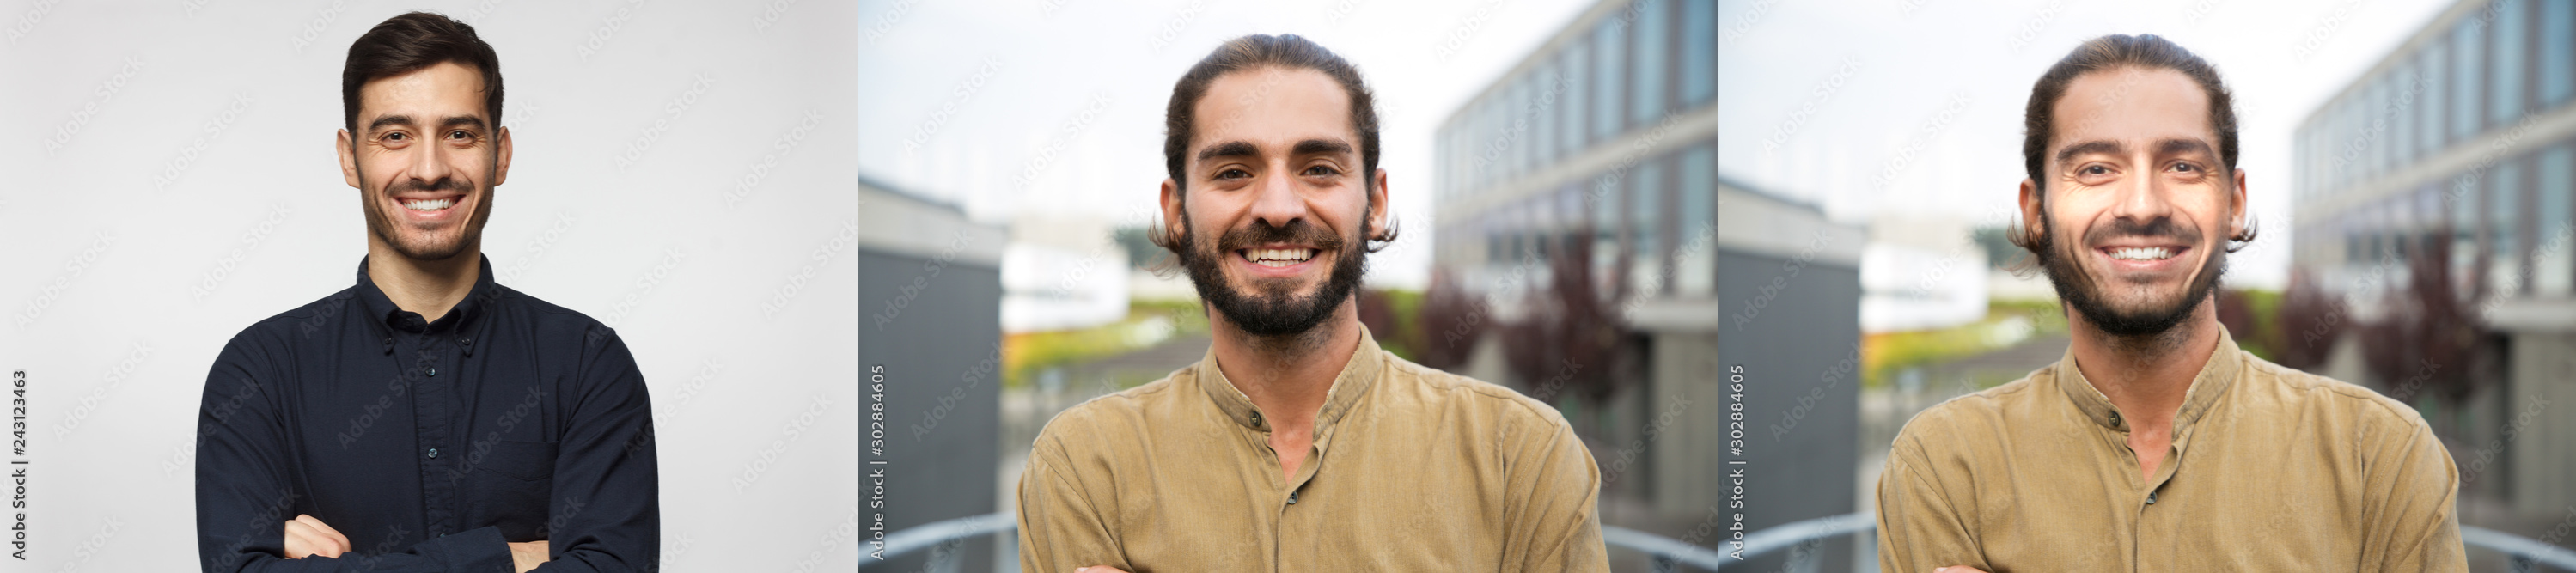

In [ ]:
import cv2
import numpy as np
import dlib
from google.colab.patches import cv2_imshow


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

def extract_landmarks(image, detector, predictor):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        return None

    landmarks = predictor(gray, faces[0])
    points = []
    for n in range(0, 68):
        points.append((landmarks.part(n).x, landmarks.part(n).y))

    return np.array(points)

def create_delaunay_triangles(rect, points):

    subdiv = cv2.Subdiv2D(rect)


    for p in points:
        subdiv.insert((float(p[0]), float(p[1])))

    triangle_list = subdiv.getTriangleList()
    delaunay_triangles = []

    for t in triangle_list:
        pts = [(int(t[0]), int(t[1])), (int(t[2]), int(t[3])), (int(t[4]), int(t[5]))]
        pt_indices = []

        for pt in pts:
            index = np.where((points == pt).all(axis=1))
            if index[0].size > 0:
                pt_indices.append(index[0][0])

        if len(pt_indices) == 3:
            delaunay_triangles.append(pt_indices)

    return delaunay_triangles

def apply_affine_transform(src, src_tri, dst_tri, size):
    """Applies affine transformation to warp a triangular region."""
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    dst = cv2.warpAffine(src, warp_mat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return dst

def warp_and_blend_face(source_img, destination_img, source_points, destination_points, delaunay_triangles):
    """Warps and blends the source face to the destination face."""
    destination_img_warped = np.copy(destination_img)

    for tri_indices in delaunay_triangles:
        src_tri = [source_points[i] for i in tri_indices]
        dst_tri = [destination_points[i] for i in tri_indices]

        # Calculate the bounding rectangle for each triangle
        src_rect = cv2.boundingRect(np.float32([src_tri]))
        dst_rect = cv2.boundingRect(np.float32([dst_tri]))

        # Warp each triangular region from the source to the destination
        src_crop = source_img[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]]
        dst_crop = destination_img_warped[dst_rect[1]:dst_rect[1] + dst_rect[3], dst_rect[0]:dst_rect[0] + dst_rect[2]]

        # Get the triangular regions from the bounding box
        src_tri = [(p[0] - src_rect[0], p[1] - src_rect[1]) for p in src_tri]
        dst_tri = [(p[0] - dst_rect[0], p[1] - dst_rect[1]) for p in dst_tri]

        # Warp triangular regions and place them on the destination image
        warped_crop = apply_affine_transform(src_crop, src_tri, dst_tri, (dst_rect[2], dst_rect[3]))
        mask = np.zeros((dst_rect[3], dst_rect[2], 3), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst_tri), (1, 1, 1), 16, 0)
        destination_img_warped[dst_rect[1]:dst_rect[1] + dst_rect[3], dst_rect[0]:dst_rect[0] + dst_rect[2]] = \
            destination_img_warped[dst_rect[1]:dst_rect[1] + dst_rect[3], dst_rect[0]:dst_rect[0] + dst_rect[2]] * (1 - mask) + \
            warped_crop * mask

    return destination_img_warped

def face_swap(source_image, destination_image):

    source_img = cv2.imread(source_image)
    destination_img = cv2.imread(destination_image)


    source_landmarks = extract_landmarks(source_img, detector, predictor)
    destination_landmarks = extract_landmarks(destination_img, detector, predictor)

    if source_landmarks is None or destination_landmarks is None:
        print("Could not detect faces in one or both images.")
        return None


    rect = (0, 0, destination_img.shape[1], destination_img.shape[0])
    delaunay_triangles = create_delaunay_triangles(rect, destination_landmarks)


    warped_face = warp_and_blend_face(source_img, destination_img, source_landmarks, destination_landmarks, delaunay_triangles)


    hull = cv2.convexHull(destination_landmarks).reshape(-1, 2)

    if hull.shape[0] < 3 or hull.shape[1] != 2:
        print("Error: Convex hull is not in the correct shape.")
        print("Hull shape:", hull.shape)
        return None

    mask = np.zeros(destination_img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, hull, 255)


    center = (hull[:,0].mean().astype(int), hull[:,1].mean().astype(int))
    seamless_face = cv2.seamlessClone(warped_face, destination_img, mask, center, cv2.NORMAL_CLONE)

    return seamless_face

def resize_image(image, target_size):

    h, w = image.shape[:2]
    aspect_ratio = w / h
    new_w = int(target_size * aspect_ratio)
    resized_image = cv2.resize(image, (new_w, target_size))
    return resized_image

def ensure_color_channels(image):

    if len(image.shape) == 2:
        return cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

def combine_images(source_image, destination_image, swapped_image):
    """Combine the source, destination, and swapped images side by side."""
    # Resize images to the same height (use the height of the destination image)
    target_height = destination_image.shape[0]
    source_image_resized = resize_image(source_image, target_height)
    swapped_image_resized = resize_image(swapped_image, target_height)

    # Ensure all images have 3 channels
    source_image_resized = ensure_color_channels(source_image_resized)
    destination_image_resized = ensure_color_channels(destination_image)
    swapped_image_resized = ensure_color_channels(swapped_image_resized)

    # Now concatenate the images horizontally
    combined = cv2.hconcat([source_image_resized, destination_image_resized, swapped_image_resized])
    return combined


if __name__ == "__main__":
    source_image_path = "/content/AdobeStock_243123463_Preview.jpeg"
    destination_image_path = "/content/AdobeStock_302884605_Preview.jpeg"


    source_img = cv2.imread(source_image_path)
    destination_img = cv2.imread(destination_image_path)


    swapped_image = face_swap(source_image_path, destination_image_path)

    if swapped_image is not None:

        combined_result = combine_images(source_img, destination_img, swapped_image)


        cv2_imshow(combined_result)
    else:
        print("Face swapping failed.")